# Model

In [1]:
# | export
from pyprojroot.here import here
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
from isssm.typing import PGSSM
from tensorflow_probability.substrates.jax.distributions import Poisson

In [2]:
# | export
def hospitalization_model(theta, aux) -> PGSSM:
    log_s2_p, log_s2_q, *log_q = theta
    log_q = jnp.array(log_q)
    s2_p = jnp.exp(log_s2_p)
    s2_q = jnp.exp(log_s2_q)
    np1, n_delay, I = aux
    n = np1 - 1

    m = n_delay + 1
    p = n_delay

    u = jnp.concatenate((-jnp.ones((1,)), log_q))
    A = jnp.diag(jnp.eye(m)[0])
    D = jnp.eye(m)
    Sigma0 = jnp.eye(m)
    Sigma = jnp.diag(jnp.array([s2_p, *jnp.repeat(s2_q, n_delay)]))

    B = jnp.hstack((jnp.ones((p, 1)), jnp.eye(p)))

    u = jnp.broadcast_to(u, (np1, m))
    A = jnp.broadcast_to(A, (n, m, m))
    D = jnp.broadcast_to(D, (n, m, m))
    Sigma = jnp.broadcast_to(Sigma, (n, m, m))
    v = jnp.zeros((np1, p))
    B = jnp.broadcast_to(B, (np1, p, m))

    def hospitalization_dist(signal, xi):
        log_I7 = xi
        log_lambda = log_I7 + signal

        return Poisson(log_rate=log_lambda)

    dist = hospitalization_dist
    xi = jnp.broadcast_to(jnp.log(I)[:, None], (np1, p))
    return PGSSM(u, A, D, Sigma0, Sigma, v, B, dist, xi)

In [3]:
data = pd.read_csv(here() / "data/processed/seven_day_H_I_by_age.csv")

unique_a = data["a"].unique()
dates = data["s"].unique()
h_by_age = [
    jnp.asarray(
        data[data["a"] == a].pivot(index="s", columns="k", values="h").to_numpy()
    )
    for a in unique_a
]
I_by_age = [
    jnp.asarray(
        data[data["a"] == a].pivot(index="s", columns="k", values="I").to_numpy()
    )[:, 0]
    for a in unique_a
]

In [4]:
a_index = -2
h = h_by_age[a_index]
I = I_by_age[a_index]
unique_a[a_index]

'80+'

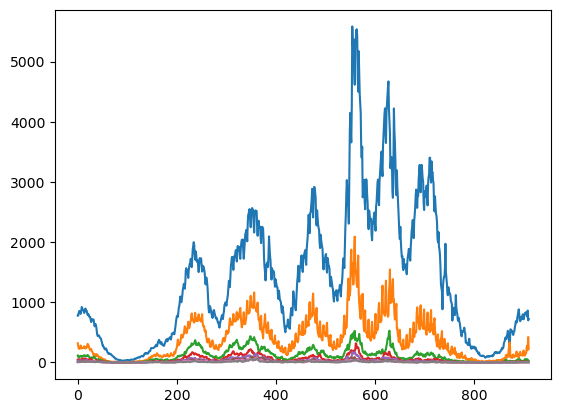

In [5]:
plt.plot(h)
plt.show()

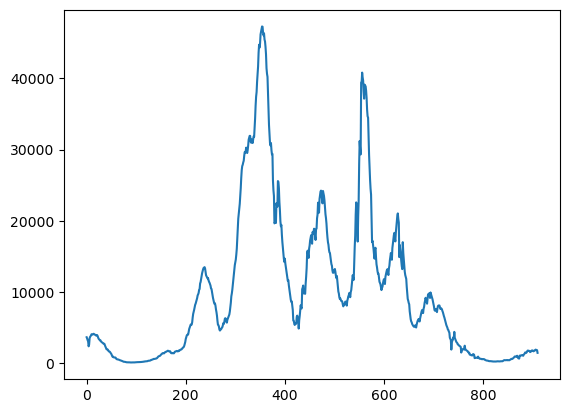

In [6]:
plt.plot(I)
plt.show()

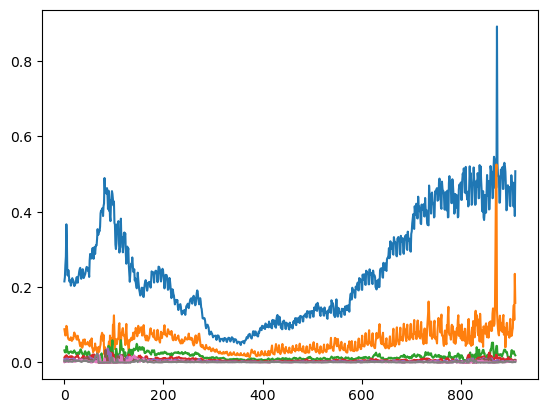

In [7]:
plt.plot(h / I[:, None])
plt.show()

In [8]:
i_start = 40
np1 = 100

pq_est = h / I[:, None]

q_est = jnp.mean(
    pq_est[i_start : i_start + np1]
    / pq_est[i_start : i_start + np1].sum(axis=1, keepdims=True),
    axis=0,
)

y = h[i_start : i_start + np1]
aux = (np1, 8, I[i_start : i_start + np1])
theta_manual = jnp.log(jnp.array([0.1**2, 0.1**2, *q_est]))

model_manual = hospitalization_model(theta_manual, aux)

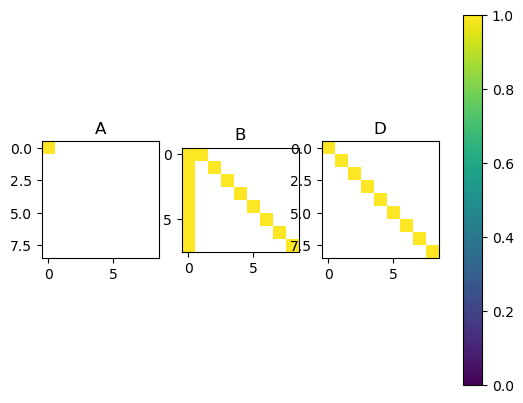

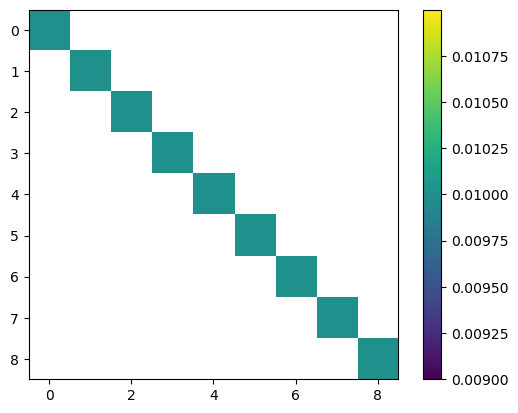

In [9]:
from ssm4epi.models.util import visualize_pgssm

visualize_pgssm(model_manual)

In [10]:
from isssm.estimation import initial_theta

theta0_result = initial_theta(y, hospitalization_model, theta_manual, aux, 10)
theta0 = theta0_result.x
theta0_result

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 2.5927624702453613
        x: [ 7.482e-02 -2.458e+00 -3.105e-01 -2.142e+00 -3.085e+00
            -3.739e+00 -4.046e+00 -4.277e+00 -4.670e+00 -4.870e+00]
      nit: 24
      jac: [ 2.422e-05 -2.956e-05 -4.844e-05  5.655e-05 -1.099e-04
            -1.944e-05 -1.078e-04 -8.494e-05  3.631e-05 -4.476e-05]
 hess_inv: [[ 7.272e+00 -7.516e+00 ...  1.914e-01  8.121e-01]
            [-7.516e+00  1.063e+01 ...  6.867e-01 -3.980e-01]
            ...
            [ 1.914e-01  6.867e-01 ...  1.885e+00 -9.852e-01]
            [ 8.121e-01 -3.980e-01 ... -9.852e-01  5.312e+00]]
     nfev: 3009
     njev: 136

In [11]:
model0 = hospitalization_model(theta0, aux)
jnp.exp(theta0)

Array([1.0776912 , 0.08558449, 0.73308766, 0.11746132, 0.04575274,
       0.02378819, 0.01749779, 0.0138791 , 0.0093704 , 0.00767067],      dtype=float32)

In [12]:
from isssm.laplace_approximation import laplace_approximation as LA
from isssm.modified_efficient_importance_sampling import (
    modified_efficient_importance_sampling as MEIS,
)
from isssm.importance_sampling import pgssm_importance_sampling, ess_pct
import jax.random as jrn

proposal_la, info_la = LA(y, model0, 100)
key = jrn.PRNGKey(423423423)
key, subkey = jrn.split(key)
samples, log_weights = pgssm_importance_sampling(
    y, model0, proposal_la.z, proposal_la.Omega, 1000, subkey
)
ess_pct(log_weights)

Array(0.03012929, dtype=float32)

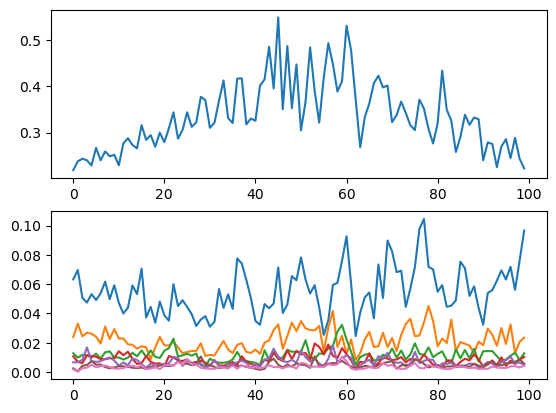

In [13]:
from isssm.importance_sampling import mc_integration

post = mc_integration(samples, log_weights)

fig, axs = plt.subplots(2, 1)
axs[0].plot(jnp.exp(post[:, 0]))
axs[1].plot(jnp.exp(post[:, 1:]))
plt.show()